In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda:0')

In [2]:
import numpy as np

In [3]:
from utils.data_utils import load_simulation_data

In [4]:
Xtr,Xte,ytr,yte,Ztr,Zte = load_simulation_data(simulation_params = {'p':100,'q':40, 'r':20, 'b':-10, 't':0}, 
                                               n1=1000, n2=400, svm=False, random_state=55, intercept=False, 
                                               train_frac = 0.7)

In [5]:
from utils.data_utils import dataset_description, input_uniqueness, initial_dataloaders
from utils.data_utils import load_data_with_name

In [6]:
args_dic = {}
args_dic['epochs'] = 100
args_dic['batch_size']=64
args_dic['AL_batch']=32
args_dic['init_num'] = 100
args_dic['tr_num'] = Xtr.shape[0]
args_dic['AL_iters'] = None # if None, we can conduct AL for whole dataset
args_dic['AL_select']='acc'
args_dic['val_ratio'] =0.2 
args_dic['val_scheduler'] ='linear' ## validation ratio scheduler add!
args_dic['problem_type'] = 'binary' 
args_dic['model_type'] ='LR'
args_dic['model_args'] ={'n_hidden':32, 'p_dropout':0.0}
args_dic['dataset'] = 'simulation'
args_dic['save_model']=True
args_dic['save_dir'] = None

In [7]:
from utils import config
args = config.Args(**args_dic)

need to set selection params!
save directory:  ../results/simulation/220313_0138


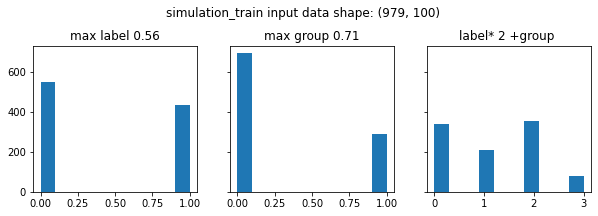

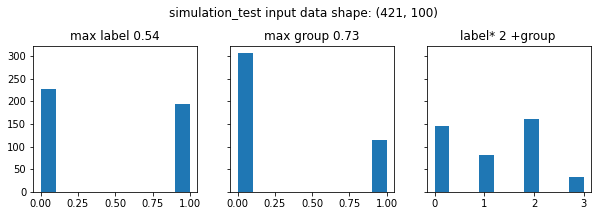

In [8]:
dataset_description(Xtr,ytr,Ztr, dataname=args.dataset+'_train')
dataset_description(Xte,yte,Zte, dataname=args.dataset+'_test')

In [9]:
input_uniqueness(Xtr,Xte)

1400 1400
satisfy uniqueness


In [10]:
args.print_args()

train epochs/batch: 100/64
AL iters/batch: 28/32
AL selection is based on  acc
initial number and validation ratio are 100/0.2
problem and models are binary/LR


In [11]:
sel_args = {"param_names":None, "last_layer":False, "sel_idxs": None, "normalize":True}
sel_type = "entropy" # identity, binary_entropy, entropy, random
args.set_selection_params(sel_type,sel_args)

In [12]:
N1 = args.init_num
train_loader, select_loader, test_loader = initial_dataloaders(Xtr,ytr,Ztr,Xte,yte,Zte,N1,args)

In [13]:
args.AL_iters

28

# Train model

In [14]:
from utils.train_utils import train_AL, train_AL_valid,train_AL_valid_trgrad

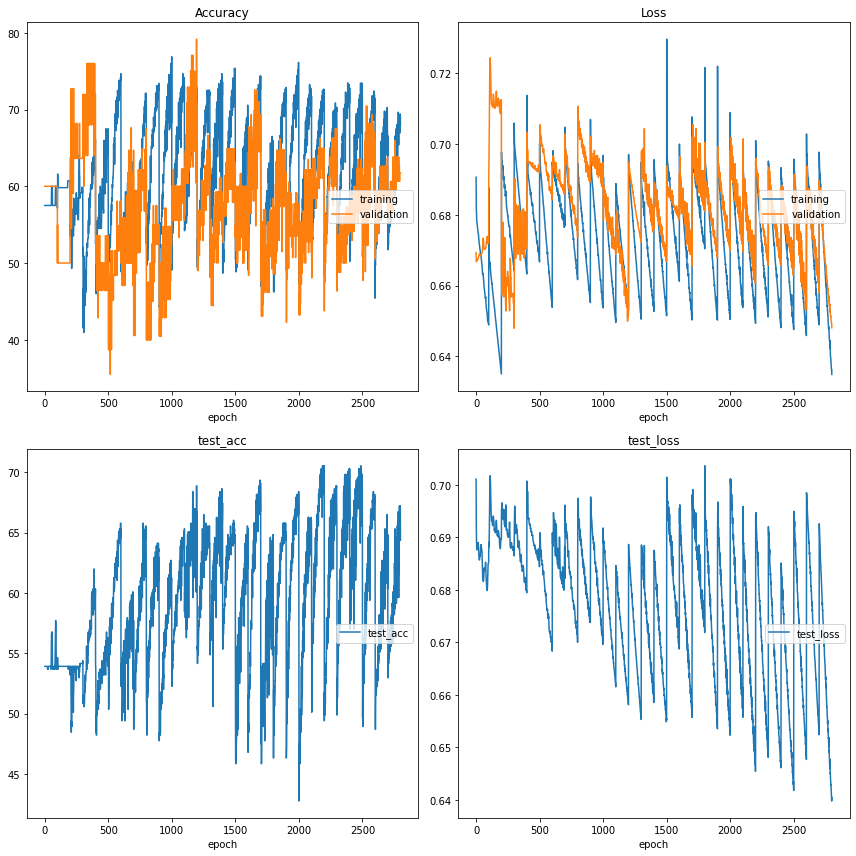

Accuracy
	training         	 (min:   40.936, max:   76.879, cur:   67.931)
	validation       	 (min:   35.484, max:   79.167, cur:   61.702)
Loss
	training         	 (min:    0.635, max:    0.730, cur:    0.635)
	validation       	 (min:    0.648, max:    0.724, cur:    0.648)
test_acc
	test_acc         	 (min:   42.755, max:   70.546, cur:   64.371)
test_loss
	test_loss        	 (min:    0.640, max:    0.704, cur:    0.640)
Finished Training
0.0 : loss 0.6559575796127319 / acc 58.46154022216797
1.0 : loss 0.6304922699928284 / acc 68.96551513671875
final dataloader is saved in  ../results/simulation/220313_0138/final_dataloader.pkl


In [15]:
clf, train_loader_p, select_loader_p, gids = train_AL_valid_trgrad(train_loader, select_loader, device, 
                                                      args, test_loader, True)

In [16]:
from utils.data_utils import save_dataloader

In [17]:
save_dataloader(args.save_dir,test_loader)

test_loader.pkl is stored in ../results/simulation/220313_0138/test_loader.pkl


In [18]:
import os

In [19]:
with open(os.path.join(args.save_dir,'train_AL_valid_trgrad.txt'),'w') as f:
    f.write(str(args_dic))
    f.write("\n")
    f.write(sel_type)
    f.write("\n")
    f.write(str(sel_args))    

In [20]:
import pickle
with open(os.path.join(args.save_dir,'selected_group_results.pkl'),'wb') as f:
    pickle.dump(gids, f)